# Recreating the previous meta-analysis

i.e. '[Understanding coralline algal responses to ocean acidification: Meta-analysis and synthesis](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.15899)' (Cornwall et al., 2022)

The R code used for the analysis (Meta-analysis Figure 5-6.Rmd), along with the two .csv datasets (juvenile_raw_data(in).csv, juvenile_raw_data(in).csv) were provided by Ben Harvey.

The following is a translation of the original R code into Python to compare and contrast with our new analysis.


In [18]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
import pandas as pd
import numpy as np
from calcification import config, analysis
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages

# R
metafor = rpackages.importr("metafor")
base = rpackages.importr("base")
mumin = rpackages.importr("MuMIn")
pandas2ri.activate()    # ensure pandas to R conversion is activated
# custom
from calcification import utils, plotting

effects_fp = config.tmp_data_dir / "effect_sizes.csv"
effects = pd.read_csv(effects_fp)

In [8]:
### load climatology for predictions and contextualising
ph_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

effects_df_mi = effects.set_index(['doi', 'location', 'longitude', 'latitude'])
effects_clim_df = effects_df_mi.join(merged_clim_df_mi, how='inner')

# length of complete effects_df - number of rows not matching up with sst_df, multiplied by number of sst rows per effect row
expected_num = (len(effects_df_mi) - len(set(effects_df_mi.index).difference(set(merged_clim_df_mi.index)))) * 12
actual_num = len(effects_clim_df)

print(f"Expected number of rows: {expected_num}")
print(f"{expected_num-actual_num}-row anomaly between climatology and effects dataframes")

Expected number of rows: 14712
4188-row anomaly between climatology and effects dataframes


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:773: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:773: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [9]:
### preprocessing
# add ID column
effects["ID"] = effects.index
working_df = effects.copy()
effect_type = "hedges_g"
treatment = "temp"

# specify model
if treatment == "phtot":
    x_var = "delta_ph"
    other_var = "temp"
elif treatment == "temp":
    x_var = "delta_t"
    other_var = "phtot"
    
formula = f"{effect_type} ~ {x_var} + {other_var} + factor(core_grouping) - 1"

# select only rows relevant to treatment
if treatment:
    working_df = working_df[working_df["treatment"] == treatment]
    print(f"Subsetted to {len(working_df)} samples for treatment {treatment}")
    n_investigation = len(working_df)
# remove nans for subset effect_type
working_df = working_df.dropna(subset=[effect_type, f"{effect_type}_var", x_var, other_var])
n_nans = n_investigation - len(working_df)

### summarise processing
print('Total samples in input data: ', len(effects))
print('Total samples of relevant investigation: ', n_investigation)
print('Dropped due to NaN values in required columns:', n_nans)
print(f'Final sample count: {len(working_df)} ({n_nans+(len(effects)-n_investigation)} rows dropped)')

# assign working_df to working_df_no_outliers
# working_df = working_df_no_outliers.copy()

Subsetted to 444 samples for treatment temp
Total samples in input data:  1284
Total samples of relevant investigation:  444
Dropped due to NaN values in required columns: 147
Final sample count: 297 (987 rows dropped)


Removed 5 outliers (from 297 samples) based on Cook's distance threshold of 0.23


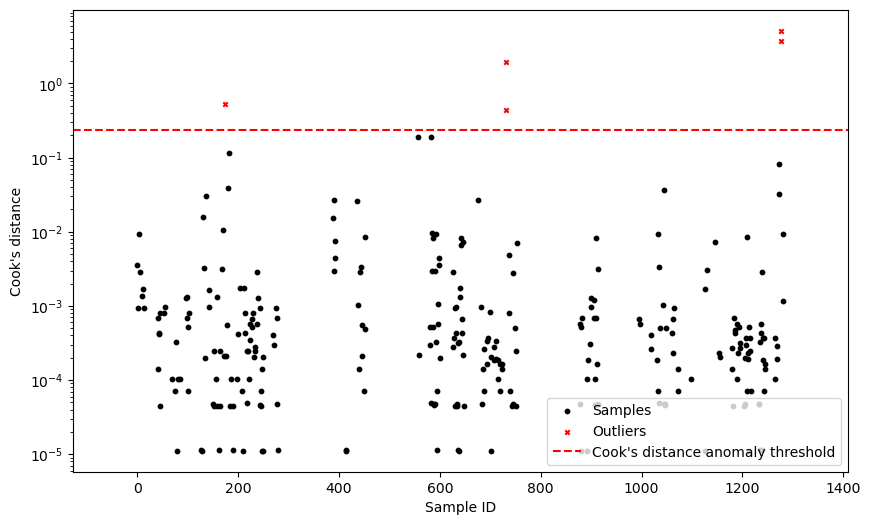

In [10]:
### visualise cooks distance
import matplotlib.pyplot as plt
import seaborn as sns

# calculate cooks distance
cooks_threshold = analysis.calc_cooks_threshold(working_df[effect_type], nparams=3)
# calculate cooks distance
working_df["cooks_d"] = analysis.calc_cooks_distance(
    working_df[effect_type]
)

# remove outliers
working_df_no_outliers = working_df[working_df["cooks_d"] < cooks_threshold]
print(f"Removed {len(working_df) - len(working_df_no_outliers)} outliers (from {len(working_df)} samples) based on Cook's distance threshold of {cooks_threshold:.2f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(working_df_no_outliers.index, working_df_no_outliers["cooks_d"], s=10, color="black", label="Samples")
# plot outliers as red dots
ax.scatter(
    working_df[working_df["cooks_d"] > cooks_threshold].ID,
    working_df[working_df["cooks_d"] > cooks_threshold]["cooks_d"],
    color="red",
    marker="x",
    s=10, label="Outliers",
)

ax.hlines(
    cooks_threshold,
    xmin=-working_df.ID.max()*.1,
    xmax=working_df.ID.max()*1.1,
    color="red",
    linestyle="--",
    label="Cook's distance anomaly threshold",
)
ax.set_xlim(
    -working_df.ID.max() * 0.1,
    working_df.ID.max() * 1.1,
)
ax.set_xlabel("Sample ID")
ax.set_ylabel("Cook's distance")
ax.set_yscale("log")
ax.legend(loc='lower right');

In [ ]:
from rpy2.robjects import pandas2ri

### running model

# convert df to R dataframe
df_r = pandas2ri.py2rpy(working_df)
vi_vector = ro.FloatVector(df_r.rx2(f'{effect_type}_var'))

# run the meta-analysis model
model = metafor.rma_mv(
    yi = ro.FloatVector(df_r.rx2(effect_type)),
    V = ro.FloatVector(df_r.rx2(f"{effect_type}_var")), 
    data=df_r,
    mods = ro.Formula(formula),
    random=ro.Formula("~ 1 | original_doi/ID")
)

model_summary = base.summary(model)
print(model_summary)


Multivariate Meta-Analysis Model (k = 297; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-466.8095   933.6190   949.6190   979.0056   950.1296   

Variance Components:

            estim    sqrt  nlvls  fixed           factor 
sigma^2.1  0.9084  0.9531     45     no     original_doi 
sigma^2.2  0.3603  0.6003    297     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 291) = 1143.7345, p-val < .0001

Test of Moderators (coefficients 1:6):
QM(df = 6) = 14.1353, p-val = 0.0282

Model Results:

                                  estimate      se     zval    pval    ci.lb 
delta_t                            -0.1202  0.0514  -2.3358  0.0195  -0.2210 
phtot                              -0.3052  0.2353  -1.2972  0.1945  -0.7663 
factor(core_grouping)CCA            2.1892  1.8847   1.1615  0.2454  -1.5049 
factor(core_grouping)Coral          2.3738  1.8676   1.2710  0.2037  -1.2868 
factor(core_grouping)Halimeda       2.5090  1.9022   1.3190  0.1872  -1.

## Training model based on MuMIn

Investigating the effect of core_groupings, families, T, pH, ecoregion


In [ ]:
### 



# print(base.summary(global_model))


Multivariate Meta-Analysis Model (k = 297; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-432.6836   865.3671   903.3671   972.4281   906.2902   

Variance Components:

            estim    sqrt  nlvls  fixed           factor 
sigma^2.1  0.5328  0.7299     45     no     original_doi 
sigma^2.2  0.3706  0.6088    297     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 280) = 895.1098, p-val < .0001

Test of Moderators (coefficients 1:17):
QM(df = 17) = 52.4766, p-val < .0001

Model Results:

                                                            estimate      se 
delta_t                                                       0.0331  0.0891 
temp                                                         -0.2017  0.0839 
factor(ecoregion)Central and Southern Great Barrier Reef      5.6873  2.2235 
factor(ecoregion)Eastern Philippines                          5.5104  2.5571 
factor(ecoregion)Fiji Islands                                 5.3922  2.

In [65]:
necessary_cols = [
    "ID",
    "original_doi",
    f"{effect_type}",
    f"{effect_type}_var",
    "delta_t",
    "delta_ph",
    "temp",
    "phtot",
    "core_grouping",
    "ecoregion",
    "realm"
]

# count nan rows in subset
working_df[necessary_cols].isna().sum(axis=1).sum()

np.int64(0)

In [ ]:
print(ro.r("summary(global_model)"))

# Check the dredge result structure
print(ro.r("head(dredge_result)"))

# Run dredge without parallel processing
ro.r("""
dredge_result <- MuMIn::dredge(global_model)
""")

In [69]:
global_formula = f"{effect_type} ~ {x_var} + temp + phtot + factor(family) + factor(ecoregion) + factor(realm) + factor(core_grouping) - 1"
global_formula = f"{effect_type} ~ {x_var} + temp + factor(ecoregion) - 1"
r_formula = ro.Formula(global_formula)

df_r = ro.pandas2ri.py2rpy(working_df)
global_model = metafor.rma_mv(
    yi = ro.FloatVector(df_r.rx2(effect_type)),
    V = ro.FloatVector(df_r.rx2(f"{effect_type}_var")), 
    mods = r_formula,
    random = ro.Formula("~ 1 | original_doi/ID"),
    data=df_r,
)

ro.r.assign("global_model", global_model)

# Set up parallel processing cluster
n_cores = 16
ro.r(f"""
# set up for MuMIn
eval(metafor:::.MuMIn)
# Create cluster
clu <- parallel::makeCluster({n_cores})
# # Load required packages on each worker
parallel::clusterEvalQ(clu, library(metafor))
parallel::clusterEvalQ(clu, library(MuMIn))

# Export the global model and other necessary objects to the cluster
parallel::clusterExport(clu, c("global_model"))

# # Run pdredge
dredge_result <- MuMIn::dredge(global_model, cluster=clu)

# # Stop the cluster
parallel::stopCluster(clu)
""")
# """)

dredge_result = ro.r("dredge_result")
dredge_df = pandas2ri.rpy2py(dredge_result)
dredge_df = pd.DataFrame(dredge_df)
dredge_df

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During sta

,delta_t,factor(ecoregion),temp,df,logLik,AICc,delta,weight
7,NaN,1,NaN,19,-432.683558,906.110799,0.000000,5.445265e-01
6,NaN,1,NaN,18,-434.068802,906.598036,0.487237,4.267926e-01
3,NaN,1,NaN,18,-436.796815,912.054061,5.943262,2.789049e-02
2,NaN,1,NaN,17,-441.493798,919.181144,13.070344,7.903689e-04
5,NaN,-2147483648,NaN,4,-473.094361,954.325707,48.214908,1.846225e-11
1,NaN,-2147483648,NaN,3,-474.723942,955.529796,49.418997,1.011161e-11
4,NaN,-2147483648,NaN,3,-475.732375,957.546661,51.435862,3.688617e-12
0,NaN,-2147483648,NaN,3,-476.860369,959.802650,53.691850,1.193938e-12


In [68]:
# view dredge_result
pd.DataFrame(dredge_df)

,delta_t,factor(ecoregion),temp,df,logLik,AICc,delta,weight
0,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
1,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
2,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
3,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
4,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
5,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
6,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125
7,NaN,1,NaN,19,-432.683558,906.110799,0.0,0.125


## Predictions

- pH (T constant)
- T (pH constant)
- variable pH and T

In [332]:
# first, test with average values
model_matrix = ro.r('model.matrix')(model)
col_means = ro.r('colMeans')(model_matrix)
prediction = ro.r('predict')(
    model, 
    newmods=col_means, 
    digits=2
)
print(prediction)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Extra argument ('useS4') disregarded. 




  pred   se ci.lb ci.ub pi.lb pi.ub 
 -0.39 0.15 -0.68 -0.09 -2.58  1.80 




(0, 10)


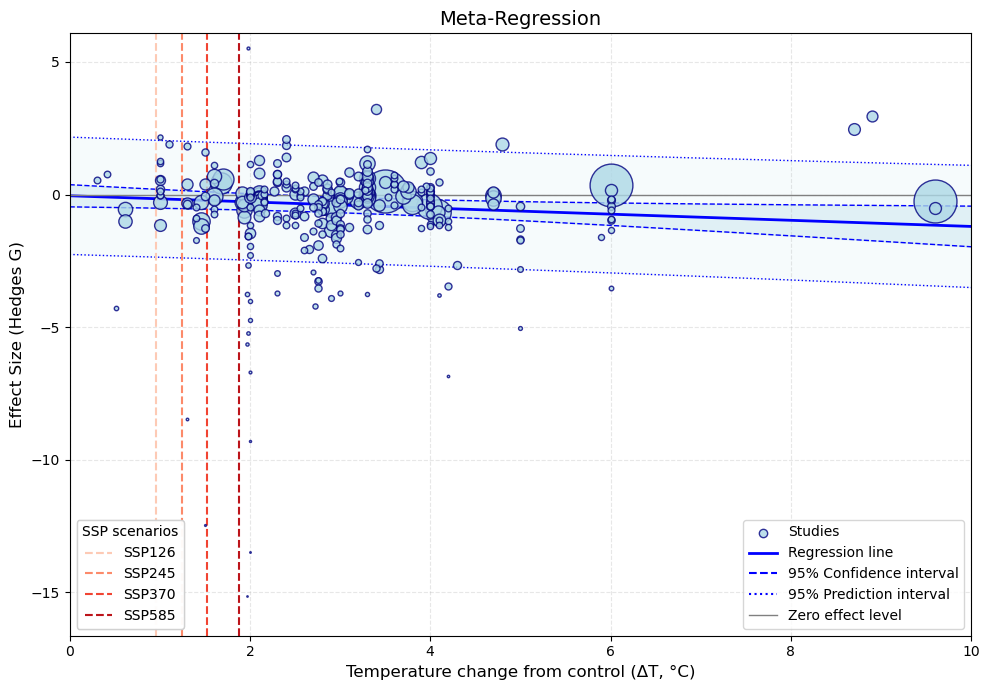

In [410]:
fig, ax = plotting.meta_regplot(model, mod_pos=0,
                      point_size="seinv", 
                      point_color='navy',
                      point_fill='lightblue',
                      ci=True,
                      refline=0,
                      shade=True,
                      ci_color='lightblue',
                      title="Meta-Regression",
                      xlim = (0, 10),
                      predlim = (0, 10),
                      xlab = "pH change from control (ΔpH)" if x_var == "delta_ph" else "Temperature change from control (ΔT, °C)",
                      ylab=f"Effect Size ({effect_type.replace('_', ' ').title()})",)

### annotate with future climatology
df = effects_clim_df
variable = x_var

scenarios = df['scenario'].unique()
colors = sns.color_palette("Reds", len(scenarios))
scenario_var = 'ph' if 'ph' in variable else 'sst'
scenario_lines = []
for i, scenario in enumerate(scenarios):
    scenario_df = df[df['scenario'] == scenario]
    line = ax.vlines(
        x=scenario_df[f'mean_{scenario_var}_20y_anomaly_ensemble'].mean(), 
        ymin=working_df[effect_type].min()*1.1, 
        ymax=working_df[effect_type].max()*1.1, 
        color=colors[i],
        linestyle='--', 
        label=scenario.upper(), 
        # zorder=10
    )
    scenario_lines.append(line)
ax.set_ylim(
    working_df[effect_type].min()*1.1, 
    working_df[effect_type].max()*1.1
)

# get existing legend
legend1 = ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
ax.add_artist(legend1)
ax.add_artist(legend2)

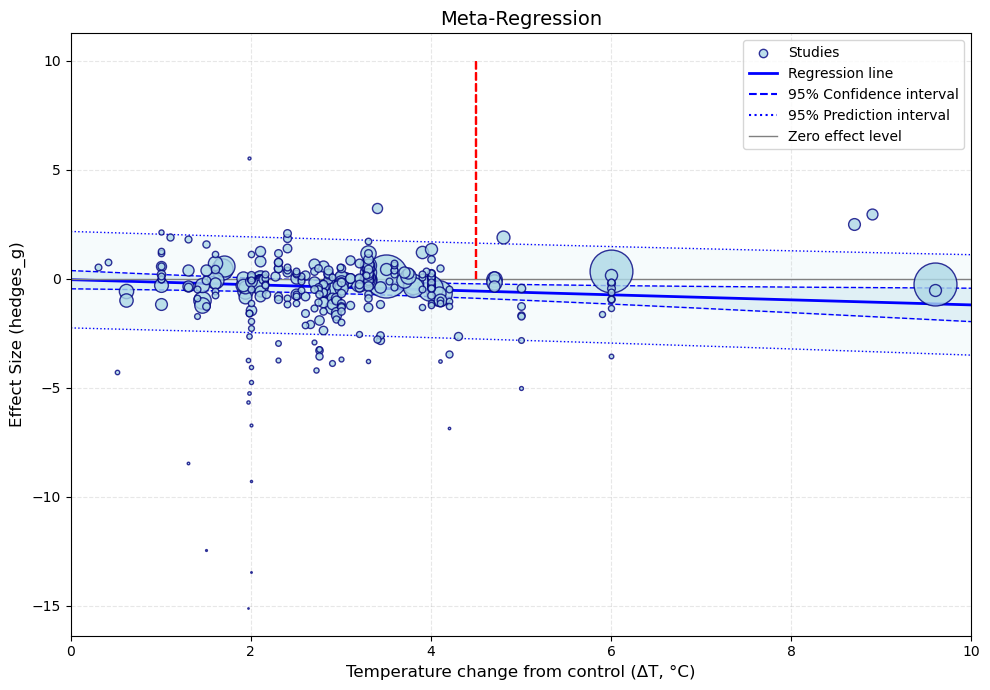

In [ ]:
# now adjust pH keeping temp constant

# Deprecated